In [1]:
#https://www.zillow.com/research/data/

In [3]:
%matplotlib inline

# Dependencies
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from census import Census
import gmaps
import shapefile as shp
import seaborn as sns
import geopandas as gpd


# Census API Key
from config import census_key_class
from config import gkey
c = Census(census_key_class, year=2013)


In [4]:
# Run Census Search to retrieve data on all zip codes (2013 ACS5 Census)
# See: https://github.com/CommerceDataService/census-wrapper for library documentation
# See: https://gist.github.com/afhaque/60558290d6efd892351c4b64e5c01e9b for labels
census_data = c.acs5.get(("NAME", "B19013_001E", "B01003_001E", "B01002_001E",
                          "B19301_001E","B17001_002E","B25077_001E","B08301_010E",
                          "B15003_022E","B23025_002E","B23025_005E",
                          "B08136_003E","B08136_007E"), {'for': 'zip code tabulation area:*'})





In [24]:

# Convert to DataFrame
census_pd = pd.DataFrame(census_data)

# Column Reordering
census_pd = census_pd.rename(columns={"B01003_001E": "Population",
                                      "B01002_001E": "Median Age",
                                      "B19013_001E": "Household Income",
                                      "B19301_001E": "Per Capita Income",
                                      "B17001_002E": "Poverty Count",
                                      "B25077_001E": "Median Home Value",
                                      "B08301_010E": "Num People Commute Public Transit",
                                      "B15003_022E": "Persons with Bachelor Degree",
                                      "B23025_002E": "People in Labor Force",
                                      "B23025_005E": "People Unemployed",
                                      "B08136_003E": "Solo Auto Commute Time (minutes)",
                                      "B08136_007E": "Public Transport Commute Time (minutes)",
                                      "NAME": "Name", "zip code tabulation area": "Zipcode"})

# Add in Poverty Rate (Poverty Count / Population)
census_pd["Poverty Rate"] = 100 * \
    census_pd["Poverty Count"].astype(
        int) / census_pd["Population"].astype(int)

# Add in Unemplyment Rate (People Unemployed / People in Labor Force)
census_pd["Unemployment Rate"] = 100 * \
    census_pd["People Unemployed"].astype(
        int) / census_pd["People in Labor Force"].astype(int)

# Final DataFrame
census_pd = census_pd[["Zipcode", "Population", "Median Age", "Household Income",
                       "Per Capita Income", "Poverty Count", "Poverty Rate",
                       "Median Home Value","Persons with Bachelor Degree",
                       "People in Labor Force","People Unemployed","Unemployment Rate" ]]

# Visualize
print(len(census_pd))
census_pd.head()

33120


,Zipcode,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemployment Rate
0,08518,5217.0,41.5,74286.0,33963.0,170.0,3.258578,206300.0,724.0,3220.0,321.0,9.968944
1,08520,27468.0,37.4,90293.0,37175.0,1834.0,6.676860,291300.0,4878.0,16187.0,1418.0,8.760116
2,08525,4782.0,47.1,118656.0,59848.0,43.0,0.899205,449700.0,1011.0,3004.0,138.0,4.593875
3,08527,54867.0,42.2,88588.0,37021.0,2191.0,3.993293,329500.0,7586.0,29204.0,2910.0,9.964388
4,08528,245.0,48.5,58676.0,49117.0,0.0,0.000000,326800.0,24.0,130.0,0.0,0.000000


In [3]:
#took out:
#"Num People Commute Public Transit"
#"Solo Auto Commute Time (minutes)"
#"Public Transport Commute Time (minutes)"


In [10]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
census_pd.to_csv("census_data.csv", encoding="utf-8", index=False)

In [6]:
census_pd1= pd.read_csv("census_data.csv")
#Read Richmond MSA Zipcodes Excel (92 zipcodes)
zipcodes_df=pd.read_excel("./Resources/zipcodes.xlsx")
#print(zipcodes_df.count())


In [11]:
#merge census df and zipcode df on zipcode to get data for Richmond MSA (92 zipcodes)
richmond_msa_census = pd.merge(zipcodes_df,census_pd1,how="left", on=['Zipcode','Zipcode'])

# Display the data table for preview
richmond_msa_census.count()

Zipcode                         92
Neighborhood                    92
Population                      92
Median Age                      92
Household Income                92
Per Capita Income               92
Poverty Count                   92
Poverty Rate                    91
Median Home Value               92
Persons with Bachelor Degree    92
People in Labor Force           92
People Unemployed               92
Unemplyment Rate                91
dtype: int64

In [21]:
richmond_msa_census.head()

,Neighborhood,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate
Zipcode,,,,,,,,,,,,
22427,Bowling Green,3702.0,31.5,42232.0,20651.0,447.0,12.074554,196800.0,246.0,2039.0,253.0,12.408043
22514,Milford,2451.0,44.6,49271.0,23579.0,239.0,9.751122,147800.0,95.0,1220.0,119.0,9.754098
22535,Port Royal,362.0,52.3,51100.0,38654.0,54.0,14.917127,239600.0,41.0,272.0,11.0,4.044118
22538,Rappahannock Academy,255.0,42.8,103021.0,33144.0,0.0,0.000000,156300.0,4.0,102.0,0.0,0.000000
22546,Ruther Glen,15952.0,36.9,61637.0,26850.0,1976.0,12.387161,186900.0,1312.0,8723.0,1166.0,13.366961


In [22]:
#remove zipcodes with no data identified by -666666666 value 

for cols in richmond_msa_census.columns.tolist()[1:]:
    richmond_msa_census = richmond_msa_census.loc[richmond_msa_census[cols] != -666666666]

print(richmond_msa_census.count())   

richmond_msa_census.columns=["Population", "Median Age", "Household Income", "Per Capita Income", "Poverty Count", 
"Poverty Rate", "Median Home Value", "Persons with Bachelor Degree", "People in Labor Force", 
"People Unemployed", "Unemployment Rate"].astype(float)

richmond_msa_census.describe()


Neighborhood                    86
Population                      86
Median Age                      86
Household Income                86
Per Capita Income               86
Poverty Count                   86
Poverty Rate                    86
Median Home Value               86
Persons with Bachelor Degree    86
People in Labor Force           86
People Unemployed               86
Unemplyment Rate                86
dtype: int64


,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,14065.627907,41.256977,64832.174419,30846.302326,1655.104651,10.288473,221924.418605,1962.069767,7474.430233,633.569767,7.817958
std,13928.426118,6.342064,23223.997299,9985.300046,2619.955357,8.237177,76892.641637,2288.413310,7438.537357,749.665816,4.253482
min,89.000000,25.300000,19231.000000,15740.000000,0.000000,0.000000,82300.000000,4.000000,26.000000,0.000000,0.000000
25%,2510.500000,37.800000,49075.250000,24374.500000,228.000000,4.696367,168975.000000,188.000000,1313.000000,77.750000,4.901338
50%,6265.000000,40.800000,61787.500000,27604.500000,570.500000,8.275472,210850.000000,837.000000,3528.500000,263.000000,7.376552
75%,25877.250000,44.075000,76434.750000,35409.000000,1937.250000,14.022141,260025.000000,3516.250000,13178.750000,942.000000,9.912751
max,50595.000000,65.200000,165234.000000,67963.000000,12983.000000,39.133858,534700.000000,8929.000000,27307.000000,2953.000000,20.588235


In [14]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
richmond_msa_census.to_csv("census_data_richmond_msa.csv", encoding="utf-8", index=False)

In [16]:
#get coordinates for Richmond MSA Zipcodes from here:http://download.geonames.org/export/zip/ by downloading US zip to desktop
us_zipcode_coords_df=pd.read_csv("./Resources/zipcode_coords/US.txt", sep='\t', header=None)
# , usecols=[1,9,10] names=["Zipcode", "Lat", "Long"] # this only reads columns we need and names them

us_zipcode_coords_df_renamed=us_zipcode_coords_df.rename(columns={1:"Zipcode", 9:"Lat", 10:"Lng" })

#us_zipcode_coords_df_renamed.head()

us_zipcode_coords_df_clean=us_zipcode_coords_df_renamed.drop([0,2,3,4,5,6,7,8,11], axis=1)
us_zipcode_coords_df_clean.head()

,Zipcode,Lat,Lng
0,99553,54.1430,-165.7854
1,99571,55.1858,-162.7211
2,99583,54.8542,-163.4113
3,99612,55.0628,-162.3056
4,99661,55.3192,-160.4914


In [17]:
#merge richmond_msa_census and us_zipcode_coords_df on Zipcode to get Richmond MSA Census by Zipcode with coordinates 

richmond_msa_data = pd.merge(richmond_msa_census,us_zipcode_coords_df_clean,how="left", on=['Zipcode'])

# Display the data table for preview
print(richmond_msa_data.count())
richmond_msa_data.head()

Zipcode                         92
Neighborhood                    92
Population                      92
Median Age                      92
Household Income                92
Per Capita Income               92
Poverty Count                   92
Poverty Rate                    91
Median Home Value               92
Persons with Bachelor Degree    92
People in Labor Force           92
People Unemployed               92
Unemplyment Rate                91
Lat                             92
Lng                             92
dtype: int64


,Zipcode,Neighborhood,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate,Lat,Lng
0,22427,Bowling Green,3702.0,31.5,42232.0,20651.0,447.0,12.074554,196800.0,246.0,2039.0,253.0,12.408043,38.0137,-77.1802
1,22514,Milford,2451.0,44.6,49271.0,23579.0,239.0,9.751122,147800.0,95.0,1220.0,119.0,9.754098,38.0058,-77.3185
2,22535,Port Royal,362.0,52.3,51100.0,38654.0,54.0,14.917127,239600.0,41.0,272.0,11.0,4.044118,38.1621,-77.1837
3,22538,Rappahannock Academy,255.0,42.8,103021.0,33144.0,0.0,0.000000,156300.0,4.0,102.0,0.0,0.000000,38.2079,-77.2502
4,22546,Ruther Glen,15952.0,36.9,61637.0,26850.0,1976.0,12.387161,186900.0,1312.0,8723.0,1166.0,13.366961,37.9451,-77.4714


In [18]:
# Save as a csv
# Note to avoid any issues later, use encoding="utf-8"
richmond_msa_data.to_csv("richmond_msa_data_final.csv", encoding="utf-8", index=False)

In [73]:
max_value=richmond_msa_data["Per Capita Income"].max()

max_value

67963.0

In [22]:
# Store 'Lat' and 'Lng' into  locations 
locations = richmond_msa_data[["Lat", "Lng"]].astype(float)


# Convert Poverty Rate to float and store
# HINT: be sure to handle NaN values
poverty_rate = richmond_msa_data["Poverty Rate"].astype(float)

# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=poverty_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 0.075)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 40
heat_layer.point_radius = 0.075

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [23]:
#https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-data.2014.html
#pip install pyshp

sns.set(style= "whitegrid", palette="pastel", color_codes=True) 
sns.mpl.rc("figure", figsize=(10,6))


In [28]:
#pip install geopandas
# pip install descartes
# set the filepath and load in a shapefile
map_df = gpd.read_file("./Resources/msa_shapefiles/richmond_msa_zip_shapes_v2.shp")
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,23086,23086,B5,G6350,S,214079105,8271160,+37.6685728,-077.0544136,"POLYGON ((-77.14329599999999 37.70315, -77.143..."
1,23089,23089,B5,G6350,S,156973737,16549281,+37.4557955,-076.9035007,"POLYGON ((-76.935571 37.45016, -76.935569 37.4..."
2,23102,23102,B5,G6350,S,76852096,2649367,+37.7081193,-077.8286536,"POLYGON ((-77.85095 37.744712, -77.85100199999..."
3,23103,23103,B5,G6350,S,96916288,3573755,+37.6480344,-077.7236401,"POLYGON ((-77.776394 37.66745299999999, -77.77..."
4,23106,23106,B5,G6350,S,69705538,987148,+37.7161066,-077.2015109,"POLYGON ((-77.169022 37.708327, -77.1689959999..."


In [206]:
map_df_renamed= map_df.rename(columns={"GEOID10":"Zipcode"})


map_df_renamed.dtypes


ZCTA5CE10     object
Zipcode       object
CLASSFP10     object
MTFCC10       object
FUNCSTAT10    object
ALAND10        int64
AWATER10       int64
INTPTLAT10    object
INTPTLON10    object
geometry      object
dtype: object

In [204]:
#map_df_renamed.plot()


In [141]:
# join the geodataframe with the cleaned up csv dataframe

richmond_msa_data2=richmond_msa_data.astype({'Zipcode': 'str'})

merged_map_df = map_df_renamed.merge(richmond_msa_data2, on="Zipcode")
merged_map_df.head()

merged_map_df.describe()

,ALAND10,AWATER10,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate,Lat,Lng
count,9.200000e+01,9.200000e+01,92.000000,9.200000e+01,9.200000e+01,9.200000e+01,92.000000,91.000000,9.200000e+01,92.000000,92.000000,92.000000,91.000000,92.000000,92.000000
mean,1.292153e+08,3.354807e+06,13311.293478,-7.246337e+06,-3.617064e+07,-7.217217e+06,1550.554348,9.788264,-4.327081e+07,1840.152174,7034.934783,600.250000,8.176367,37.490280,-77.465777
std,1.324745e+08,6.975261e+06,13770.314675,6.950481e+07,1.519781e+08,6.950788e+07,2563.361895,8.289545,1.655631e+08,2260.194108,7384.899309,736.420697,6.144209,0.283152,0.266097
min,4.314010e+05,0.000000e+00,0.000000,-6.666667e+08,-6.666667e+08,-6.666667e+08,0.000000,0.000000,-6.666667e+08,0.000000,0.000000,0.000000,0.000000,36.837300,-78.179400
25%,3.428916e+07,4.958482e+05,2266.750000,3.712500e+01,4.711550e+04,2.356000e+04,175.250000,4.187027,1.581750e+05,177.250000,1104.250000,67.000000,4.876039,37.329375,-77.636200
50%,8.941693e+07,1.361862e+06,5659.500000,4.045000e+01,5.898150e+04,2.722450e+04,493.500000,7.667905,2.054000e+05,715.500000,3155.500000,251.500000,7.432432,37.512100,-77.442100
75%,1.895279e+08,2.962683e+06,25827.000000,4.392500e+01,7.570425e+04,3.369375e+04,1807.500000,13.250756,2.506500e+05,3347.500000,12751.250000,875.250000,9.968679,37.669775,-77.320825
max,6.727370e+08,5.518490e+07,50595.000000,6.520000e+01,1.652340e+05,6.796300e+04,12983.000000,39.133858,5.347000e+05,8929.000000,27307.000000,2953.000000,48.963731,38.207900,-76.823700


In [32]:
merged_map_df.to_csv("merged_map_data.csv", encoding="utf-8", index=False)


In [223]:
merged_map_df["Population"].max()

50595.0

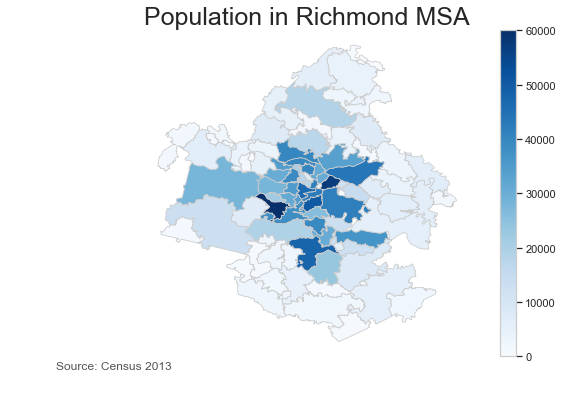

In [225]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
variable = "Population"
# set the range for the choropleth
vmin, vmax = 0, 60000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Population in Richmond MSA", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013", xy=(0.1, .08), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

#plt.savefig("map3",dpi = 300)

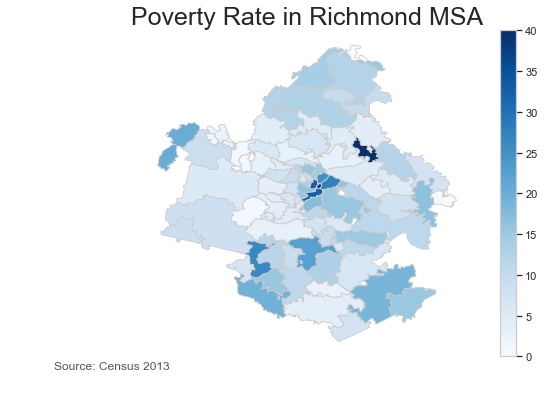

In [184]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
variable = "Poverty Rate"
# set the range for the choropleth
vmin, vmax = 0, 40
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Poverty Rate in Richmond MSA", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013", xy=(0.1, .08), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

#plt.savefig("map3",dpi = 300)
            
            

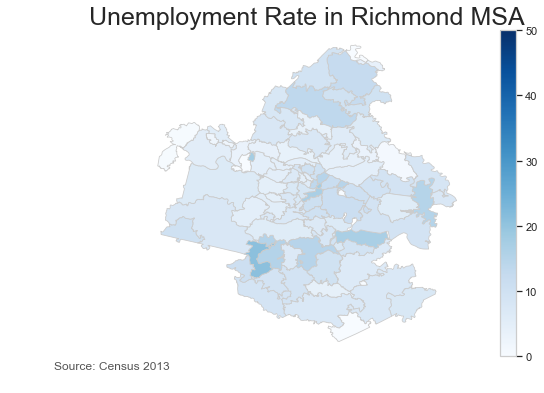

In [185]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
variable = "Unemplyment Rate"
# set the range for the choropleth
vmin, vmax = 0, 50
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
merged_map_df.plot(column=variable, cmap="Blues", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Unemployment Rate in Richmond MSA", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013", xy=(0.1, .08), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

#plt.savefig("map3",dpi = 300)
            

In [85]:
merged_map_df["Per Capita Income"].dtypes

dtype('float64')

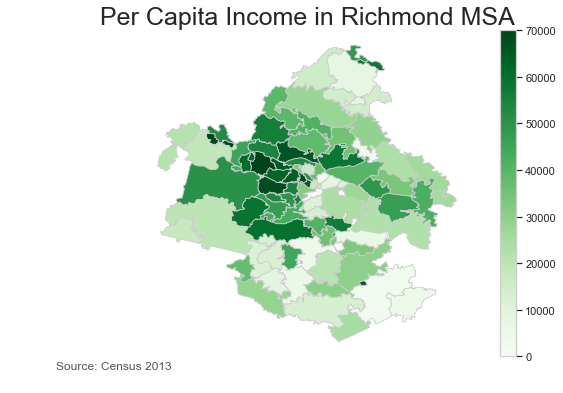

In [136]:
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
# set a variable that will call whatever column we want to visualise on the map
per_capita_income = merged_map_df["Per Capita Income"].astype(str)

variable = per_capita_income
# set the range for the choropleth
vmin, vmax = 0, 70000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
merged_map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Per Capita Income in Richmond MSA", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013", xy=(0.1, .08), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

#plt.savefig("map3",dpi = 300)

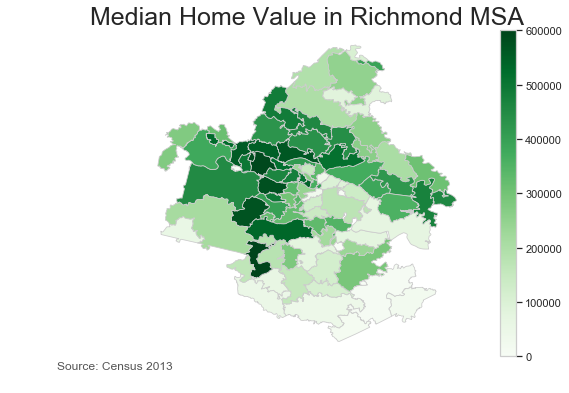

In [157]:


# set a variable that will call whatever column we want to visualise on the map
median_home_value= merged_map_df["Median Home Value"].astype(str)

variable = median_home_value
# set the range for the choropleth
vmin, vmax = 0, 600000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(10, 6))
# create map
merged_map_df.plot(column=variable, cmap="Greens", linewidth=0.8, ax=ax, edgecolor="0.8")

# remove the axis
ax.axis("off")

# add a title
ax.set_title("Median Home Value in Richmond MSA", fontdict={"fontsize": "25", "fontweight" : "3"})
# create an annotation for the data source
ax.annotate("Source: Census 2013", xy=(0.1, .08), 
            xycoords="figure fraction", 
            horizontalalignment="left", 
            verticalalignment="top", 
            fontsize=12, color="#555555")

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="Greens", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

#plt.savefig("map3",dpi = 300)

In [202]:
new_merged_map_df= merged_map_df


for cols in new_merged_map_df.columns.tolist()[1:]:
    new_merged_map_df = new_merged_map_df.loc[new_merged_map_df[cols] != -666666666]
    
new_merged_map_df.describe()

,ALAND10,AWATER10,Population,Median Age,Household Income,Per Capita Income,Poverty Count,Poverty Rate,Median Home Value,Persons with Bachelor Degree,People in Labor Force,People Unemployed,Unemplyment Rate,Lat,Lng
count,8.600000e+01,8.600000e+01,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,1.377458e+08,3.586631e+06,14065.627907,41.256977,64832.174419,30846.302326,1655.104651,10.288473,221924.418605,1962.069767,7474.430233,633.569767,7.817958,37.498499,-77.468587
std,1.328809e+08,7.159249e+06,13928.426118,6.342064,23223.997299,9985.300046,2619.955357,8.237177,76892.641637,2288.413310,7438.537357,749.665816,4.253482,0.285780,0.270200
min,9.170100e+05,0.000000e+00,89.000000,25.300000,19231.000000,15740.000000,0.000000,0.000000,82300.000000,4.000000,26.000000,0.000000,0.000000,36.837300,-78.179400
25%,3.859322e+07,6.518992e+05,2510.500000,37.800000,49075.250000,24374.500000,228.000000,4.696367,168975.000000,188.000000,1313.000000,77.750000,4.901338,37.342825,-77.640000
50%,9.554470e+07,1.535276e+06,6265.000000,40.800000,61787.500000,27604.500000,570.500000,8.275472,210850.000000,837.000000,3528.500000,263.000000,7.376552,37.514500,-77.451550
75%,1.930044e+08,3.290804e+06,25877.250000,44.075000,76434.750000,35409.000000,1937.250000,14.022141,260025.000000,3516.250000,13178.750000,942.000000,9.912751,37.695950,-77.319275
max,6.727370e+08,5.518490e+07,50595.000000,65.200000,165234.000000,67963.000000,12983.000000,39.133858,534700.000000,8929.000000,27307.000000,2953.000000,20.588235,38.207900,-76.823700


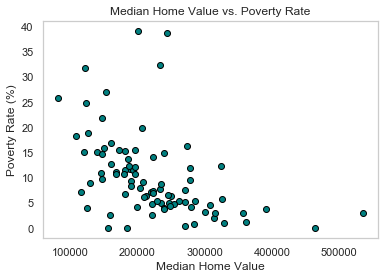

In [226]:

plt.scatter(new_merged_map_df["Median Home Value"],new_merged_map_df["Poverty Rate"], marker="o",
            facecolors="teal", edgecolors="black")

# Incorporate the other graph properties
plt.title("Median Home Value vs. Poverty Rate")
plt.ylabel("Poverty Rate (%)")
plt.xlabel("Median Home Value")
plt.grid(None)

# Save the figure
#plt.savefig("CityLatvsWindSpeed.png",bbox_inches="tight", dpi = 300)

# Show plot
plt.show()

In [ ]:
 # Convert poverty rate as a list
# Convert bank rate to list
poverty_rate = census_data["Poverty Rate"].tolist()  # Create a map using state centroid coordinates to set markers
marker_locations = census_data[['Latitude', 'Longitude']]

# Create a marker_layer using the poverty list to fill the info box
fig = gmaps.figure()
markers = gmaps.marker_layer(marker_locations,
    info_box_content=[f"Poverty Rate: {rate}" for rate in poverty_rate])
fig.add_layer(markers)
fig


population map
